In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
import torchvision.transforms as

     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 948 kB 65.0 MB/s 
     |████████████████████████████████| 58 kB 3.3 MB/s 
     |████████████████████████████████| 59 kB 5.0 MB/s 
     |████████████████████████████████| 232 kB 50.0 MB/s 
     |████████████████████████████████| 11.1 MB 50.5 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tsfm = T.Compose([
                  T.ToTensor(),
                  T.Normalize(mean=[0.5],
                              std=[0.5]),
                  T.Lambda(lambda img: img.to(device))
])

trn_ds = MNIST('/content/',train=True,transform=tsfm, download=True)
val_ds = MNIST('/content/',train=False,transform=tsfm,download=True)

trn_dl = DataLoader(trn_ds,batch_size=256,shuffle=True,drop_last=True)
val_dl = DataLoader(val_ds,batch_size=256,shuffle=False,drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [11]:
class Conv_AE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,stride=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,stride=1)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,kernel_size=3,stride=2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32,16,kernel_size=5,stride=3,padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16,1,kernel_size=2,stride=2,padding=1),
        nn.Tanh()
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [12]:
def train_batch(img,model,optimizer,criterion):
  model.train()
  output = model(img)
  loss = criterion(output,img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss

@torch.no_grad()
def validate_batch(img,model,criterion):
  model.eval()
  output = model(img)
  loss = criterion(output,img)
  return loss

model = Conv_AE().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-5)
criterion = nn.MSELoss()

EPOCH: 1.000	trn_loss: 0.511	val_loss: 0.423	(45.46s - 409.15s remaining)
EPOCH: 2.000	trn_loss: 0.377	val_loss: 0.353	(94.53s - 378.14s remaining)
EPOCH: 3.000	trn_loss: 0.266	val_loss: 0.150	(144.45s - 337.06s remaining)
EPOCH: 4.000	trn_loss: 0.128	val_loss: 0.106	(193.96s - 290.95s remaining)
EPOCH: 5.000	trn_loss: 0.100	val_loss: 0.090	(234.56s - 234.56s remaining)
EPOCH: 6.000	trn_loss: 0.088	val_loss: 0.082	(274.99s - 183.33s remaining)
EPOCH: 7.000	trn_loss: 0.081	val_loss: 0.076	(314.76s - 134.90s remaining)
EPOCH: 8.000	trn_loss: 0.077	val_loss: 0.073	(355.24s - 88.81s remaining)
EPOCH: 9.000	trn_loss: 0.073	val_loss: 0.070	(395.00s - 43.89s remaining)
EPOCH: 10.000	trn_loss: 0.071	val_loss: 0.067	(435.02s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 1163.45it/s]


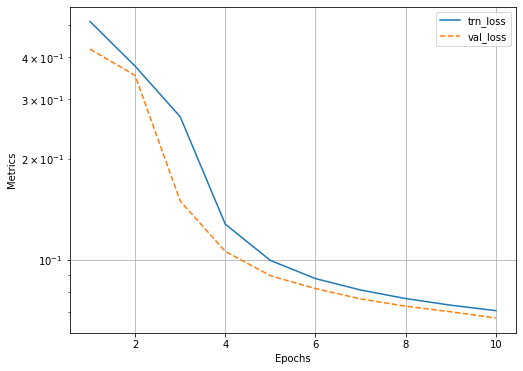

In [13]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, (img, _) in enumerate(iter(trn_dl)):
    loss = train_batch(img,model,optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')
  
  for ix, (img, _) in enumerate(iter(val_dl)):
    loss = validate_batch(img,model,criterion)
    log.record(epoch+(ix+1)/N,val_loss=loss,end='\r')
  log.report_avgs(epoch+1)
log.plot_epochs(log=True)

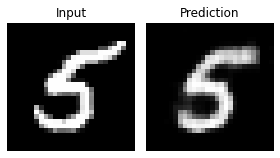

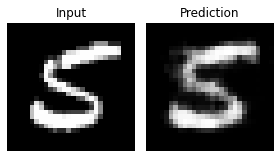

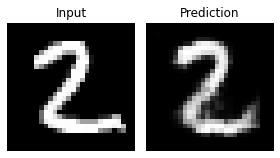

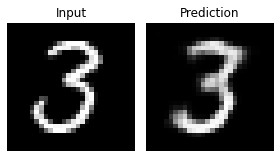

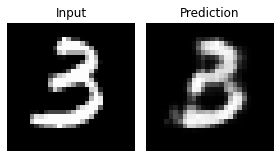

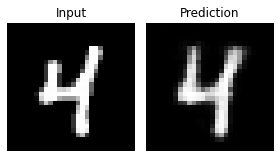

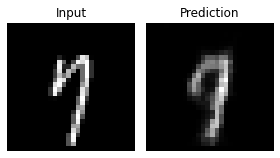

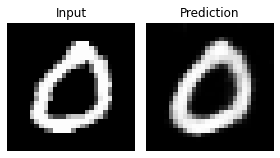

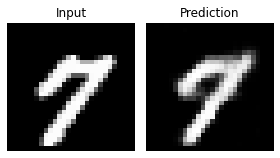

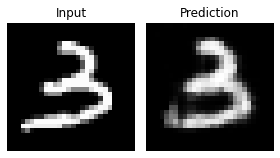

In [16]:
for _ in range(10):
  ix = np.random.randint(len(val_ds))
  img, _ = val_ds[ix]
  _img = model(img[None])[0]
  fig, ax = plt.subplots(1,2,figsize=(4,4))
  show(img[0],ax=ax[0],title='Input')
  show(_img[0],ax=ax[1],title='Prediction')
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


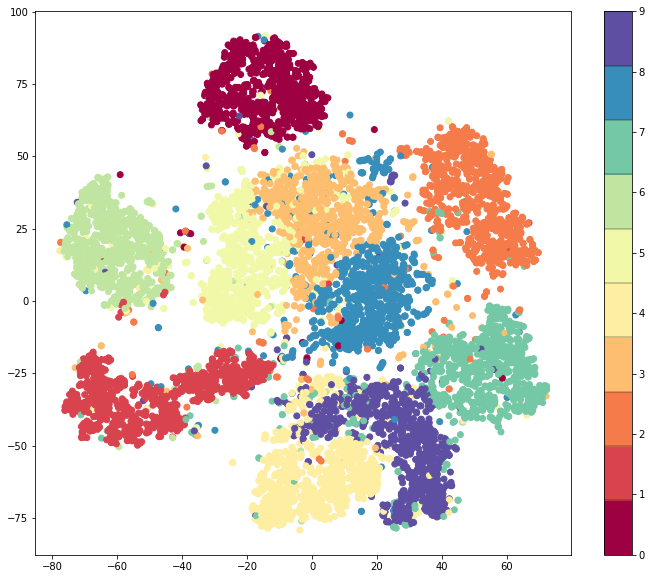

In [24]:
latent_vectors = []
classes = []

for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

from sklearn.manifold import TSNE
tsne = TSNE(2)

clustered = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [47]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)

In [48]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(9984,-1)

In [49]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

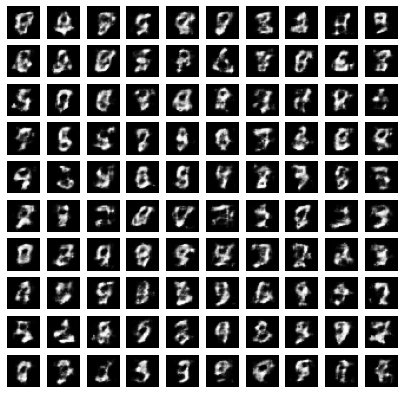

In [50]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))